In [238]:
# import sys
import os
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
from generate_csvs import generate_csvs_from_text_file
from collections import OrderedDict



#if fig directory doesn't exist in local directory, create it.
if not os.path.isdir("fig"):
    print("creating folder directory:")
    print(os.path.join(os.getcwd(),"fig"))
    os.mkdir("fig")

# Local utility functions


def csv2df(csv_file):
    """Import csv as dataframe with field propagationCycles"""
    try:
        df = pd.read_csv(csv_file)
    except Exception as e:
        print(f"Error reading the CSV file: {e}")
        return None

    # Check if the required column exists
    assert (
        "propagationCycles" in df.columns
    ), "Must contain column_color propagationCycles.\n   Headers: " + str(
        df.columns.to_list()
    )

    # Remove leading and trailing spaces
    df.columns = df.columns.str.strip()

    return df


def import_results(filename):
    """From csv, form DataFrame with standard fields
    propagationCycles, compute_time, and algorithm
    """
    df_csv = csv2df(filename)
    df = pd.DataFrame()
    for col in df_csv.columns.drop("propagationCycles"):
        df_new = df_csv.loc[:, ["propagationCycles", col]]
        df_new.rename(columns={col: "compute_time"}, inplace=True)
        df_new["algorithm"] = col
        df = pd.concat([df, df_new], axis=0, ignore_index=True)
    return df


def concat_assert(df1, df2):
    assert df1.columns.equals(df2.columns), (
        "Columns are not the same! "
        + "\n   top columns:    "
        + str(df1.columns.to_list())
        + "\n   bottom columns: "
        + str(df2.columns.to_list())
    )
    return pd.concat([df1, df2], axis=0, ignore_index=True)


def stack_results(filename, new_column=None, value=None, df=None):
    """import csv and add to df frame, append prefix to each series.

    Assume all tables will have variable "propagationCycles" with the same values
    """
    df_new = import_results(filename)
    if new_column is not None:
        # Set provided column_color
        df_new[new_column] = value

    if df is not None:
        df_new = concat_assert(df, df_new)

    return df_new


def algorithm_stats(df: pd.DataFrame):
    """Compute statistics across multiple runs.
    Same propagationCycles, algorithm, and compiler
    """
    assert isinstance(df, pd.DataFrame), "data must be a dataframe"
    result = (
        df.groupby(["propagationCycles", "algorithm", "compiler", "function"])
        .agg(
            mean=("compute_time", "mean"),
            std=("compute_time", "std"),
            count=("compute_time", "count"),
        )
        .reset_index()
    )

    # Add confidence interval
    n = result["count"]
    std_dev = result["std"]
    confidence_level = 0.95
    alpha = 1 - confidence_level
    degrees_of_freedom = n - 1
    t_score = stats.t.ppf(1 - alpha / 2, degrees_of_freedom)
    margin_of_errors = t_score * (std_dev / np.sqrt(n))
    result["confidence"] = margin_of_errors
    return result

## Convert txt files to csv

In [239]:
print("MSVC:")
generate_csvs_from_text_file("./output_msvc_250129.txt", "MSVC", output_dir="csv")
print("RHEL:")
generate_csvs_from_text_file("./output_rhel_250129.txt", "rhel", output_dir="csv")

print("MSVC:")
generate_csvs_from_text_file("./output_rk4_msvc_250130.txt", "MSVC", output_dir="csv")
print("RHEL:")
generate_csvs_from_text_file("./output_rk4_rhel_250130.txt", "rhel", output_dir="csv")

MSVC:
Created CSV: csv\MSVC_ennui_python.csv
Created CSV: csv\MSVC_ennui_cpp.csv
Created CSV: csv\MSVC_rk4_cpp.csv
Created CSV: csv\MSVC_rk4_python.csv
RHEL:
Created CSV: csv\rhel_ennui_python.csv
Created CSV: csv\rhel_ennui_cpp.csv
Created CSV: csv\rhel_ennui_python1.csv
Created CSV: csv\rhel_ennui_cpp1.csv
Created CSV: csv\rhel_rk4_cpp.csv
Created CSV: csv\rhel_rk4_python.csv
Created CSV: csv\rhel_rk4_cpp1.csv
Created CSV: csv\rhel_rk4_python1.csv
MSVC:
Created CSV: csv\MSVC_rk4_cpp.csv
Created CSV: csv\MSVC_rk4_python.csv
RHEL:
Created CSV: csv\rhel_rk4_cpp.csv
Created CSV: csv\rhel_rk4_python.csv
Created CSV: csv\rhel_rk4_cpp1.csv
Created CSV: csv\rhel_rk4_python1.csv


## Read in all ENNUI benchmarks as single dataframe

In [240]:
# Ennui
df = None
compiler = "MSVC"
filename = os.path.join(".", "csv", "msvc_ennui_python.csv")
df = stack_results(filename, "compiler", compiler, df)
filename = os.path.join(".", "csv", "msvc_ennui_cpp.csv")
df = stack_results(filename, "compiler", compiler, df)
# Per run_all.sh, Clang is run first
compiler = "Clang"
filename = os.path.join(".", "csv", "rhel_ennui_python.csv")
df = stack_results(filename, "compiler", compiler, df)
filename = os.path.join(".", "csv", "rhel_ennui_cpp.csv")
df = stack_results(filename, "compiler", compiler, df)
compiler = "GCC"
filename = os.path.join(".", "csv", "rhel_ennui_python1.csv")
df = stack_results(filename, "compiler", compiler, df)
filename = os.path.join(".", "csv", "rhel_ennui_cpp1.csv")
df = stack_results(filename, "compiler", compiler, df)
df["function"] = "ennui"
df_ennui = df


# RK4
df = None
compiler = "MSVC"
filename = os.path.join(".", "csv", "msvc_rk4_python.csv")
df = stack_results(filename, "compiler", compiler, df)
filename = os.path.join(".", "csv", "msvc_rk4_cpp.csv")
df = stack_results(filename, "compiler", compiler, df)
compiler = "Clang"
filename = os.path.join(".", "csv", "rhel_rk4_python.csv")
df = stack_results(filename, "compiler", compiler, df)
filename = os.path.join(".", "csv", "rhel_rk4_cpp.csv")
df = stack_results(filename, "compiler", compiler, df)
compiler = "GCC"
filename = os.path.join(".", "csv", "rhel_rk4_python1.csv")
df = stack_results(filename, "compiler", compiler, df)
filename = os.path.join(".", "csv", "rhel_rk4_cpp1.csv")
df = stack_results(filename, "compiler", compiler, df)
df["function"] = "rk4"


df = concat_assert(df_ennui, df)
df = algorithm_stats(df)

# Rename algorithms for consistency
df["algorithm"] = df["algorithm"].replace(
    {
        "EnnuiC++": "pureC++",
        "benchmark_rk4_integration_single_step_pybind11": "pybind11_python_loop",
        "benchmark_rk4_integration_single_step_nanobind": "nanobind_python_loop",
        "benchmark_rk4_integration_pybind11": "pybind11_C_loop",
        "benchmark_rk4_integration_nanobind": "nanobind_C_loop",
        "rk4_cpp": "pureC++",
    }
)


print("Unique algorithms: ")
print(df["algorithm"].unique())
print("Unique compilers: " + str(df["compiler"].unique()))
print("Unique functions: " + str(df["function"].unique()))

df

Unique algorithms: 
['pureC++' 'nanobind_C_loop' 'nanobind_python_loop' 'numpy_python_loop'
 'pybind11_C_loop' 'pybind11_python_loop']
Unique compilers: ['Clang' 'GCC' 'MSVC']
Unique functions: ['ennui' 'rk4']


,propagationCycles,algorithm,compiler,function,mean,std,count,confidence
0,10,pureC++,Clang,ennui,0.000006,1.260611e-06,10,9.017868e-07
1,10,pureC++,GCC,ennui,0.000006,1.284016e-06,10,9.185300e-07
2,10,pureC++,MSVC,ennui,0.000017,5.955288e-06,10,4.260157e-06
3,10,nanobind_C_loop,Clang,ennui,0.000005,3.164046e-06,10,2.263422e-06
4,10,nanobind_C_loop,GCC,ennui,0.000004,1.609910e-07,10,1.151660e-07
...,...,...,...,...,...,...,...,...
127,1000000,pybind11_python_loop,GCC,rk4,0.288914,3.433372e-02,10,2.456086e-02
128,1000000,pybind11_python_loop,MSVC,rk4,0.542166,3.254587e-02,10,2.328191e-02
129,1000000,pureC++,Clang,rk4,0.001888,6.542148e-05,10,4.679971e-05
130,1000000,pureC++,GCC,rk4,0.001921,8.620397e-05,10,6.166661e-05


In [241]:
# Sort algorithms in order of predicted speed (slowest to fastest)

# Convert the 'Category' column_color to a categorical type with the specified order
column = "algorithm"
order = [
    "numpy_python_loop",
    "pybind11_python_loop",
    "nanobind_python_loop",
    "pybind11_C_loop",
    "nanobind_C_loop",
    "pureC++",
]
# order = ['pybind11_python_loop',
# 'pybind11_C_loop', 'nanobind_python_loop', 'nanobind_C_loop','numpy_python_loop', 'pureC++']
df[column] = pd.Categorical(df[column], categories=order, ordered=True)


# Rename algorithms for brevity
df["algorithm"] = df["algorithm"].replace(
    {
        "numpy_python_loop": "NP_PL",
        "pybind11_python_loop": "PB_PL",
        "nanobind_python_loop": "NB_PL",
        "pybind11_C_loop": "PB_CL",
        "nanobind_C_loop": "NB_CL",
        "pureC++":"C++"
    }
)

# Convert the 'Category' column_color to a categorical type with the specified order
column = "compiler"
order = ["MSVC", "GCC", "Clang"]
# order = ['GCC','Clang','MSVC']
df[column] = pd.Categorical(df[column], categories=order, ordered=True)

# Sort the DataFrame by the 'Category' column using the custom order
df = df.sort_values(
    by=["propagationCycles", "algorithm", "compiler"], ignore_index=True
)

df

C:\Users\djforem\AppData\Local\Temp\ipykernel_5536\3887143488.py:19: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["algorithm"] = df["algorithm"].replace(


,propagationCycles,algorithm,compiler,function,mean,std,count,confidence
0,10,NP_PL,MSVC,ennui,0.002398,0.000273,10,0.000195
1,10,NP_PL,GCC,ennui,0.001957,0.000026,10,0.000018
2,10,NP_PL,Clang,ennui,0.002108,0.000379,10,0.000271
3,10,PB_PL,MSVC,ennui,0.000088,0.000010,10,0.000007
4,10,PB_PL,GCC,ennui,0.000036,0.000012,10,0.000009
...,...,...,...,...,...,...,...,...
127,1000000,NB_CL,GCC,rk4,0.002994,0.000105,10,0.000075
128,1000000,NB_CL,Clang,rk4,0.003128,0.000128,10,0.000092
129,1000000,C++,MSVC,rk4,0.001880,0.000085,10,0.000061
130,1000000,C++,GCC,rk4,0.001921,0.000086,10,0.000062


## Plotting functions

In [242]:
# Define plotting function
def line_plot_box(df: pd.DataFrame, column=None, figsize=(4, 3), filename=None,colors=["blue","orange","green","red","purple","brown"],markers=["o","x","^","s","p","d","D"]):

    assert isinstance(df, pd.DataFrame), "df must be a dataframe"

    # Create a figure for the overlay plot
    plt.figure(figsize=figsize)

    if filename is not None:
        # Set the style for the plots
        plt.style.use(["science", "ieee"])

    for i,val in enumerate(df[column].unique()):

        this_df = df[df[column] == val]

        # Plotting
        plt.errorbar(
            this_df["propagationCycles"],
            # mean_runtime[algorithm],
            this_df["mean"],
            yerr=this_df["confidence"],
            capsize=5,
            #ecolor='black',
            color=colors[i%len(colors)],
            markersize=2.5,            
            capthick=0.4,
            # marker=".",
            marker=markers[i%len(markers)],
            label=val,
        )

    # Set both axes to logarithmic scale
    plt.xscale("log")
    plt.yscale("log")

    # Adding titles and labels
    plt.xlabel("Propagation Cycles")
    plt.ylabel("Mean Runtime (sec.)")
    plt.xticks(df["propagationCycles"])
    plt.grid()
    if column is not None:
        plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, format="eps")  # Save the figure
    # plt.show()  # Show the plot


def bar_plot(df: pd.DataFrame, column_x, column_color, figsize=(4, 3), filename=None,colors=["blue","orange","green","red","purple","brown"],capsize=4):

    assert isinstance(df, pd.DataFrame), "df must be a dataframe"

    # Create a figure for the overlay plot
    plt.figure(figsize=figsize)

    if filename is not None:
        # Set the style for the plots
        plt.style.use(["science", "ieee"])

    num_x_ticks = len(df[column_x].unique())
    X = np.arange(num_x_ticks)
    num_bars_in_group = len(df[column_color].unique())
    gap_between_bargroups = 0.15  # where 1.0 means the distance between the first bar of a group to the first of the next
    gap_between_bars_in_group = 0.0

    bar_width = (
        (1.0 - gap_between_bargroups) + gap_between_bars_in_group
    ) / num_bars_in_group
    
    assert len(colors) >= num_bars_in_group, "need more colors!"

    for i, (key, c) in enumerate(
        zip(df[column_color].unique(), colors[:num_bars_in_group])
    ):
        this_df = df[df[column_color] == key]
        y = this_df["mean"]
        errors = this_df["confidence"]
        plt.bar(
            X + i * bar_width,
            y,
            color=c,
            width=bar_width - gap_between_bars_in_group,
            align="center",
        )
        plt.errorbar(
            X + i * bar_width,
            y,
            yerr=errors,
            fmt="none",
            color="black",
            capsize=capsize,                 
            capthick=0.4,
            elinewidth=0.6,
            label="_nolegend_",
        )
    xlabels = df[column_x].unique()
    plt.yscale("log")
    # the minus 2 is important
    plt.xticks(
        [r + bar_width * (num_bars_in_group - 1) / 2 for r in range(num_x_ticks)],
        labels=xlabels,
    )
    plt.ylabel("Mean Runtime (sec.)")
    plt.legend(df[column_color].unique(), loc="upper left")  # title='Groups'
    plt.grid()

    # plt.show()
    # return plt

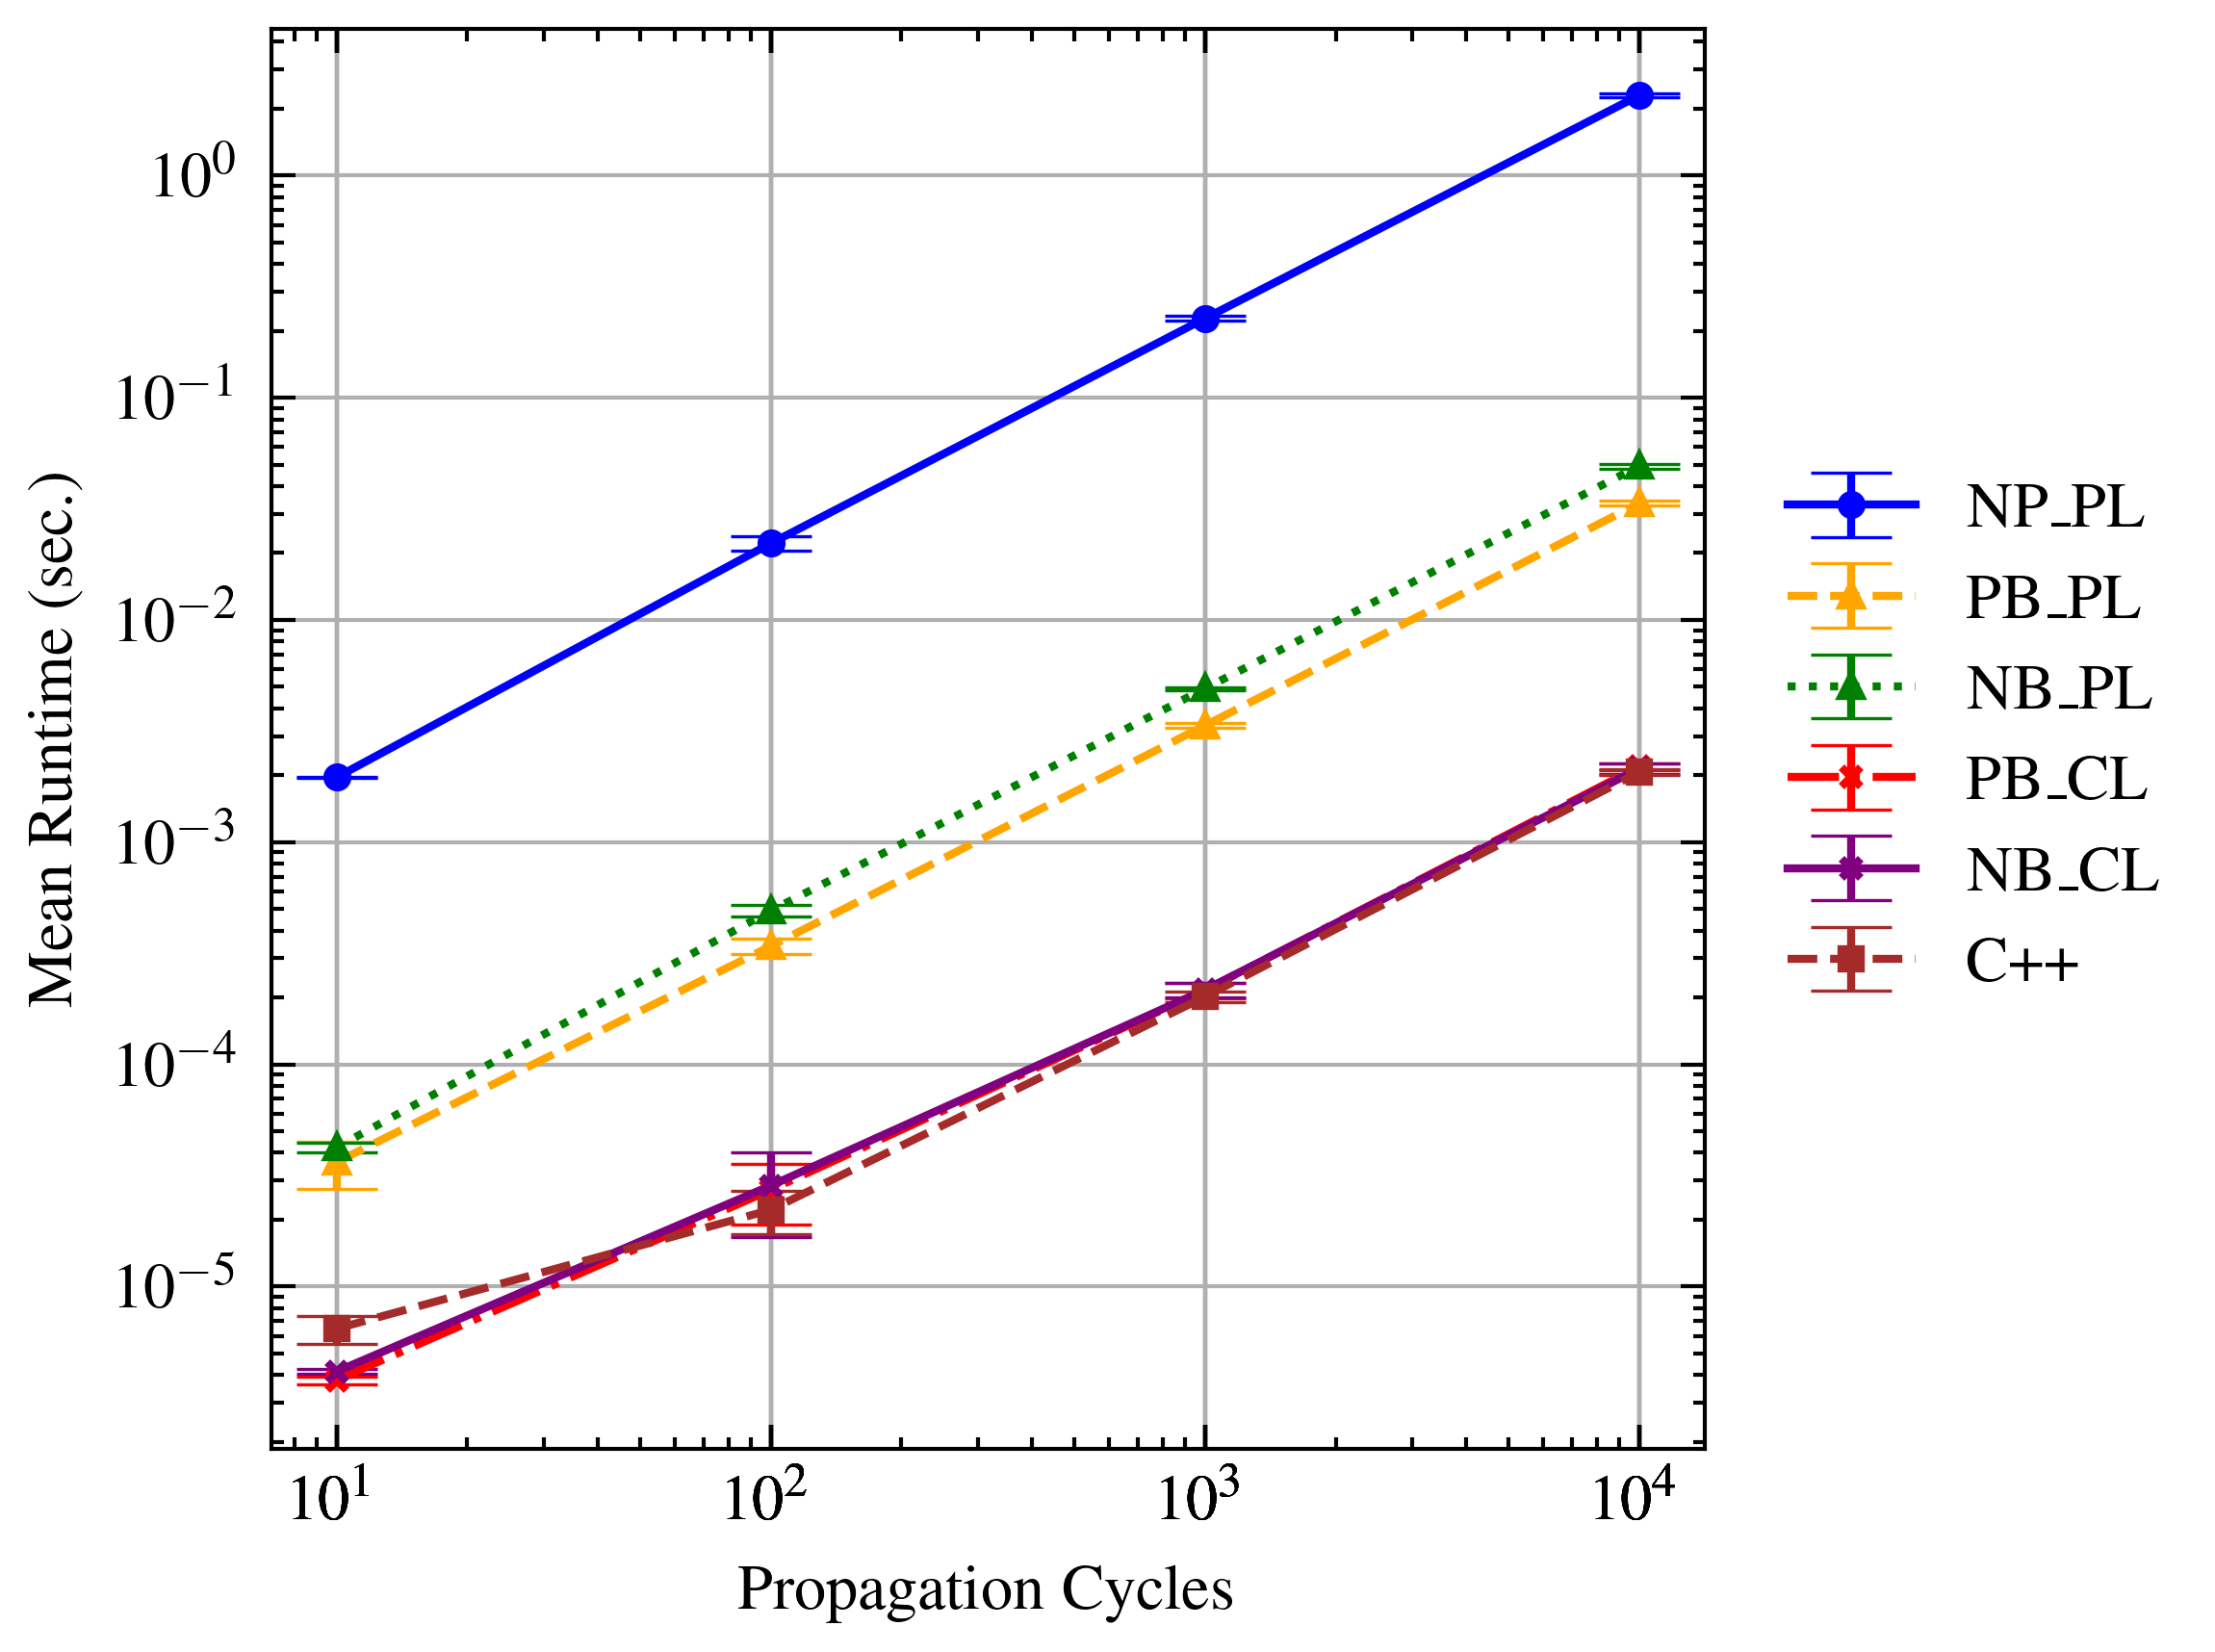

In [243]:
func = "ennui"
compiler = "GCC"
suffix = "line.eps"
filename = os.path.join(".", "fig", "_".join((func, compiler, suffix)))

this_df = df[(df["function"] == func) & (df["compiler"] == compiler)]
this_df
line_plot_box(this_df, column="algorithm", filename=filename,markers=["o","^","^","x","x","s"])

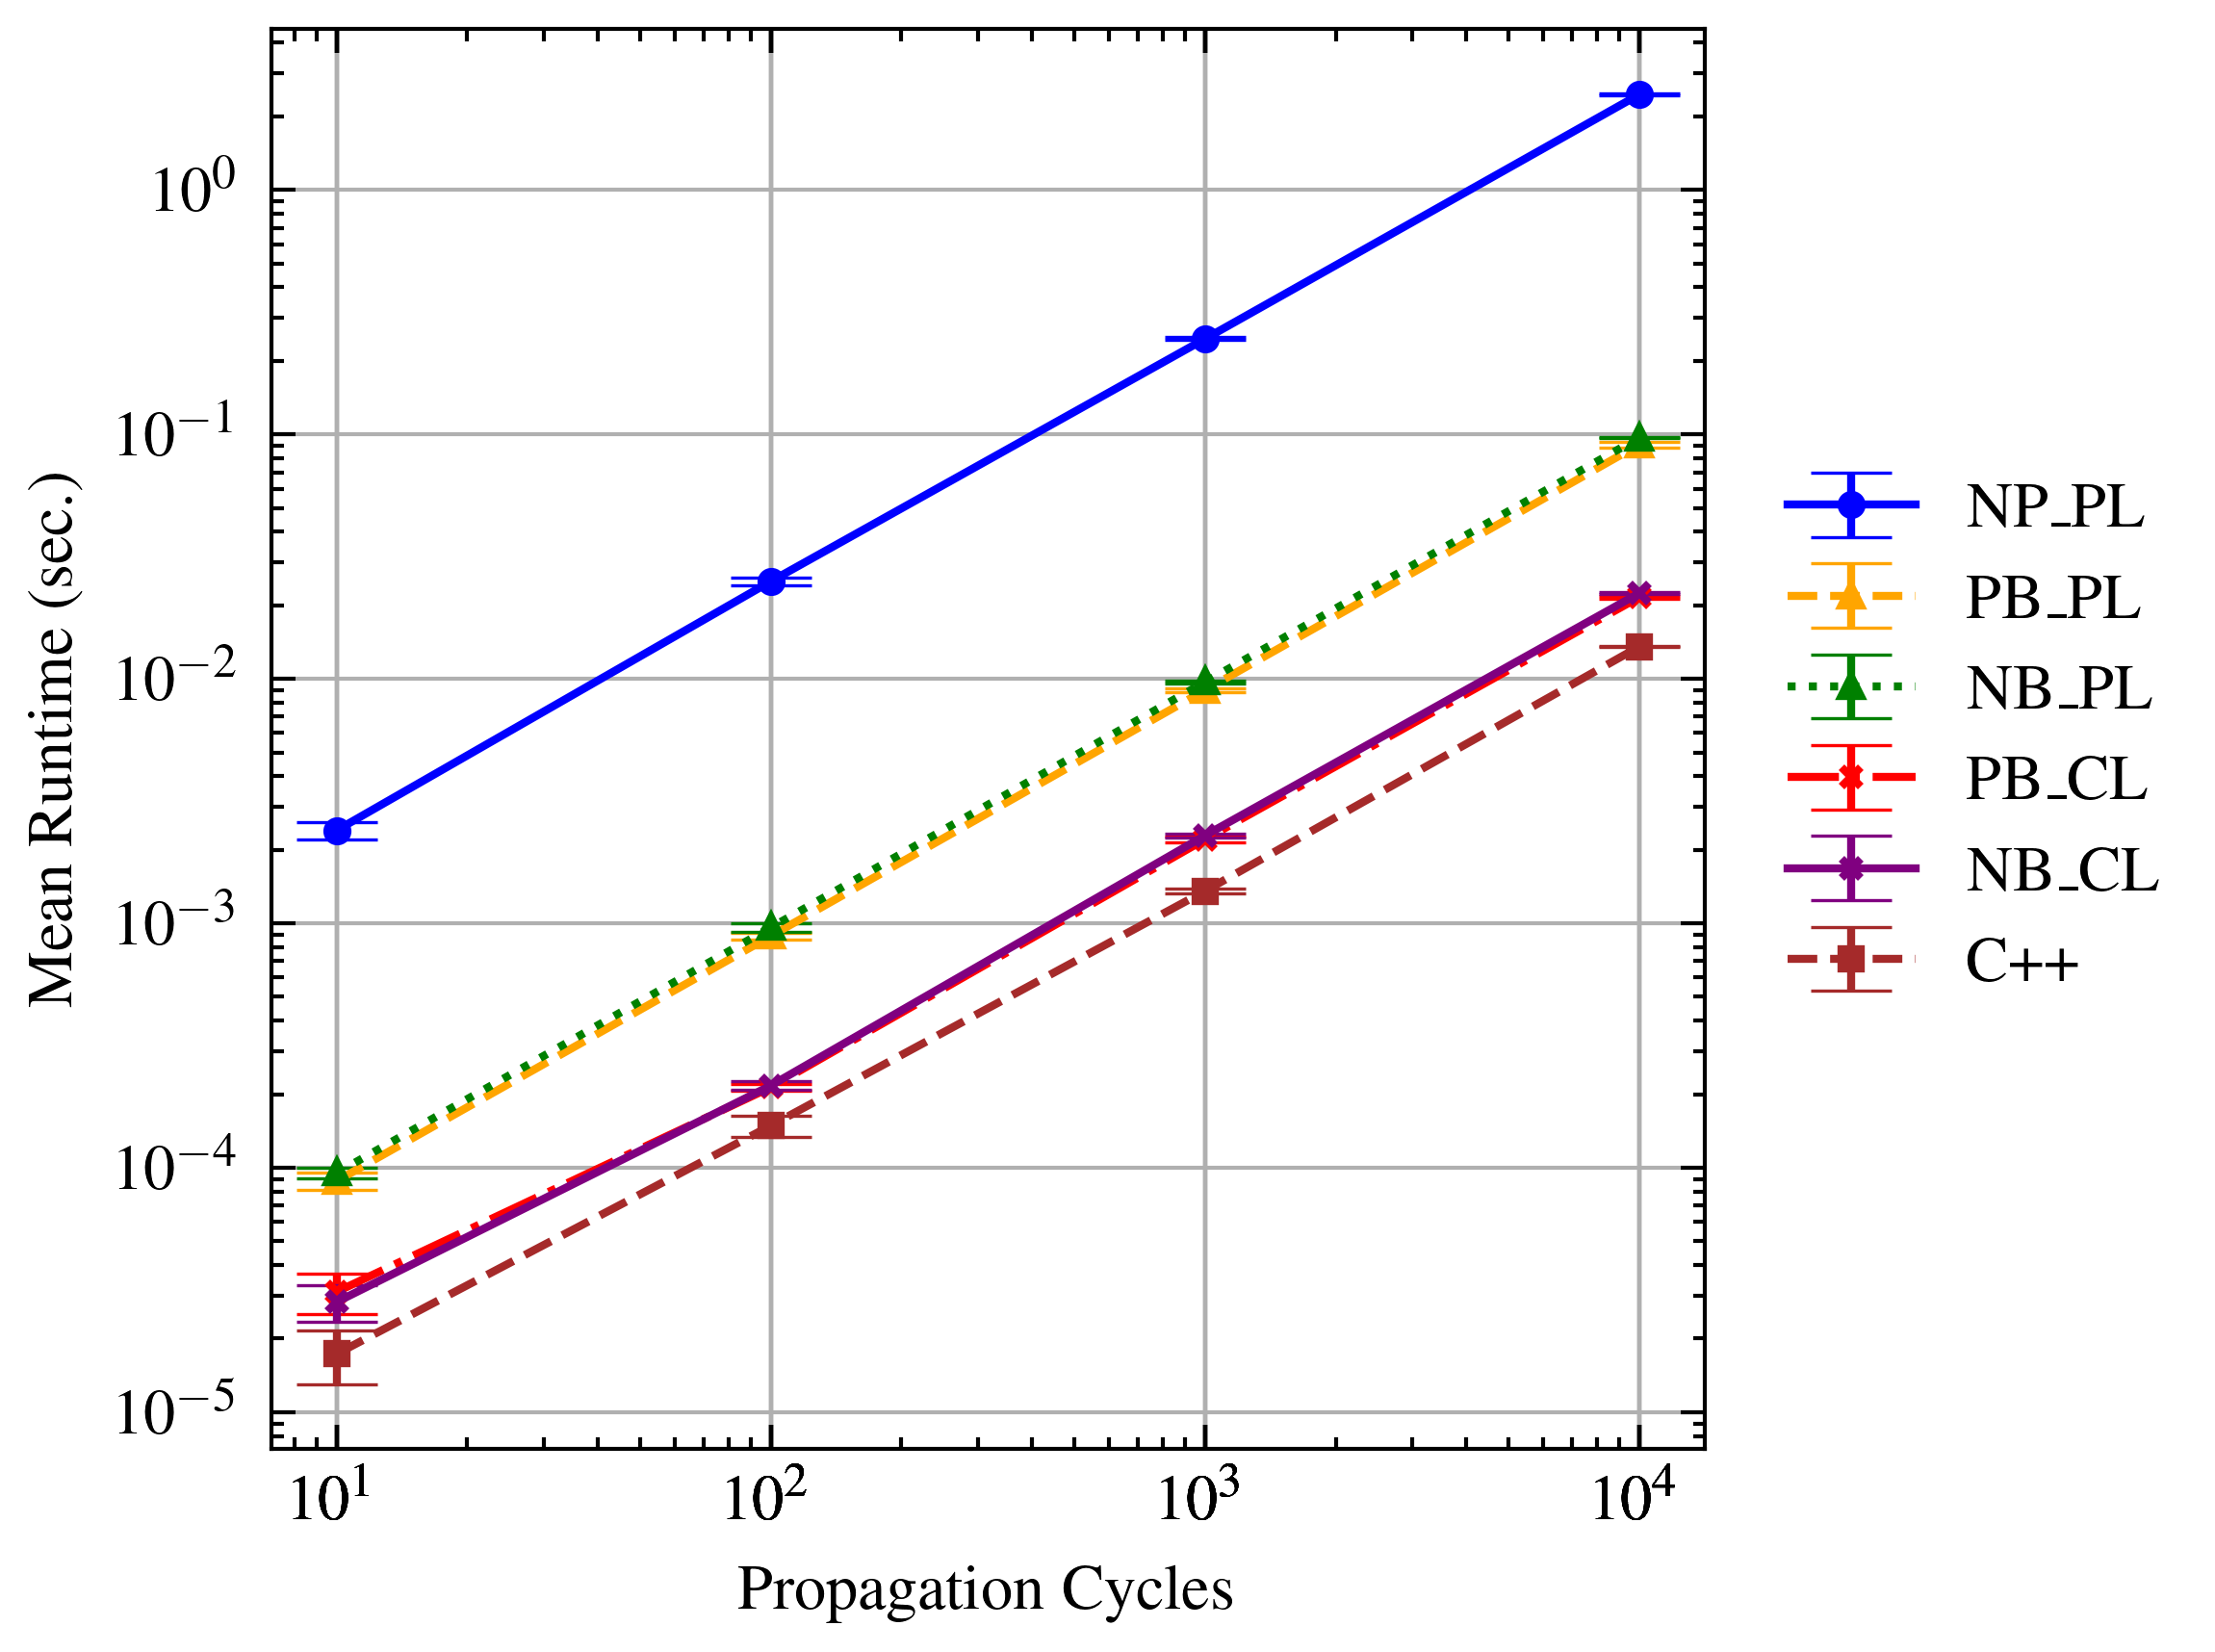

In [244]:
func = "ennui"
compiler = "MSVC"
suffix = "line.eps"
filename = os.path.join(".", "fig", "_".join((func, compiler, suffix)))

this_df = df[(df["function"] == func) & (df["compiler"] == compiler)]
this_df
line_plot_box(this_df, column="algorithm", filename=filename,markers=["o","^","^","x","x","s"])

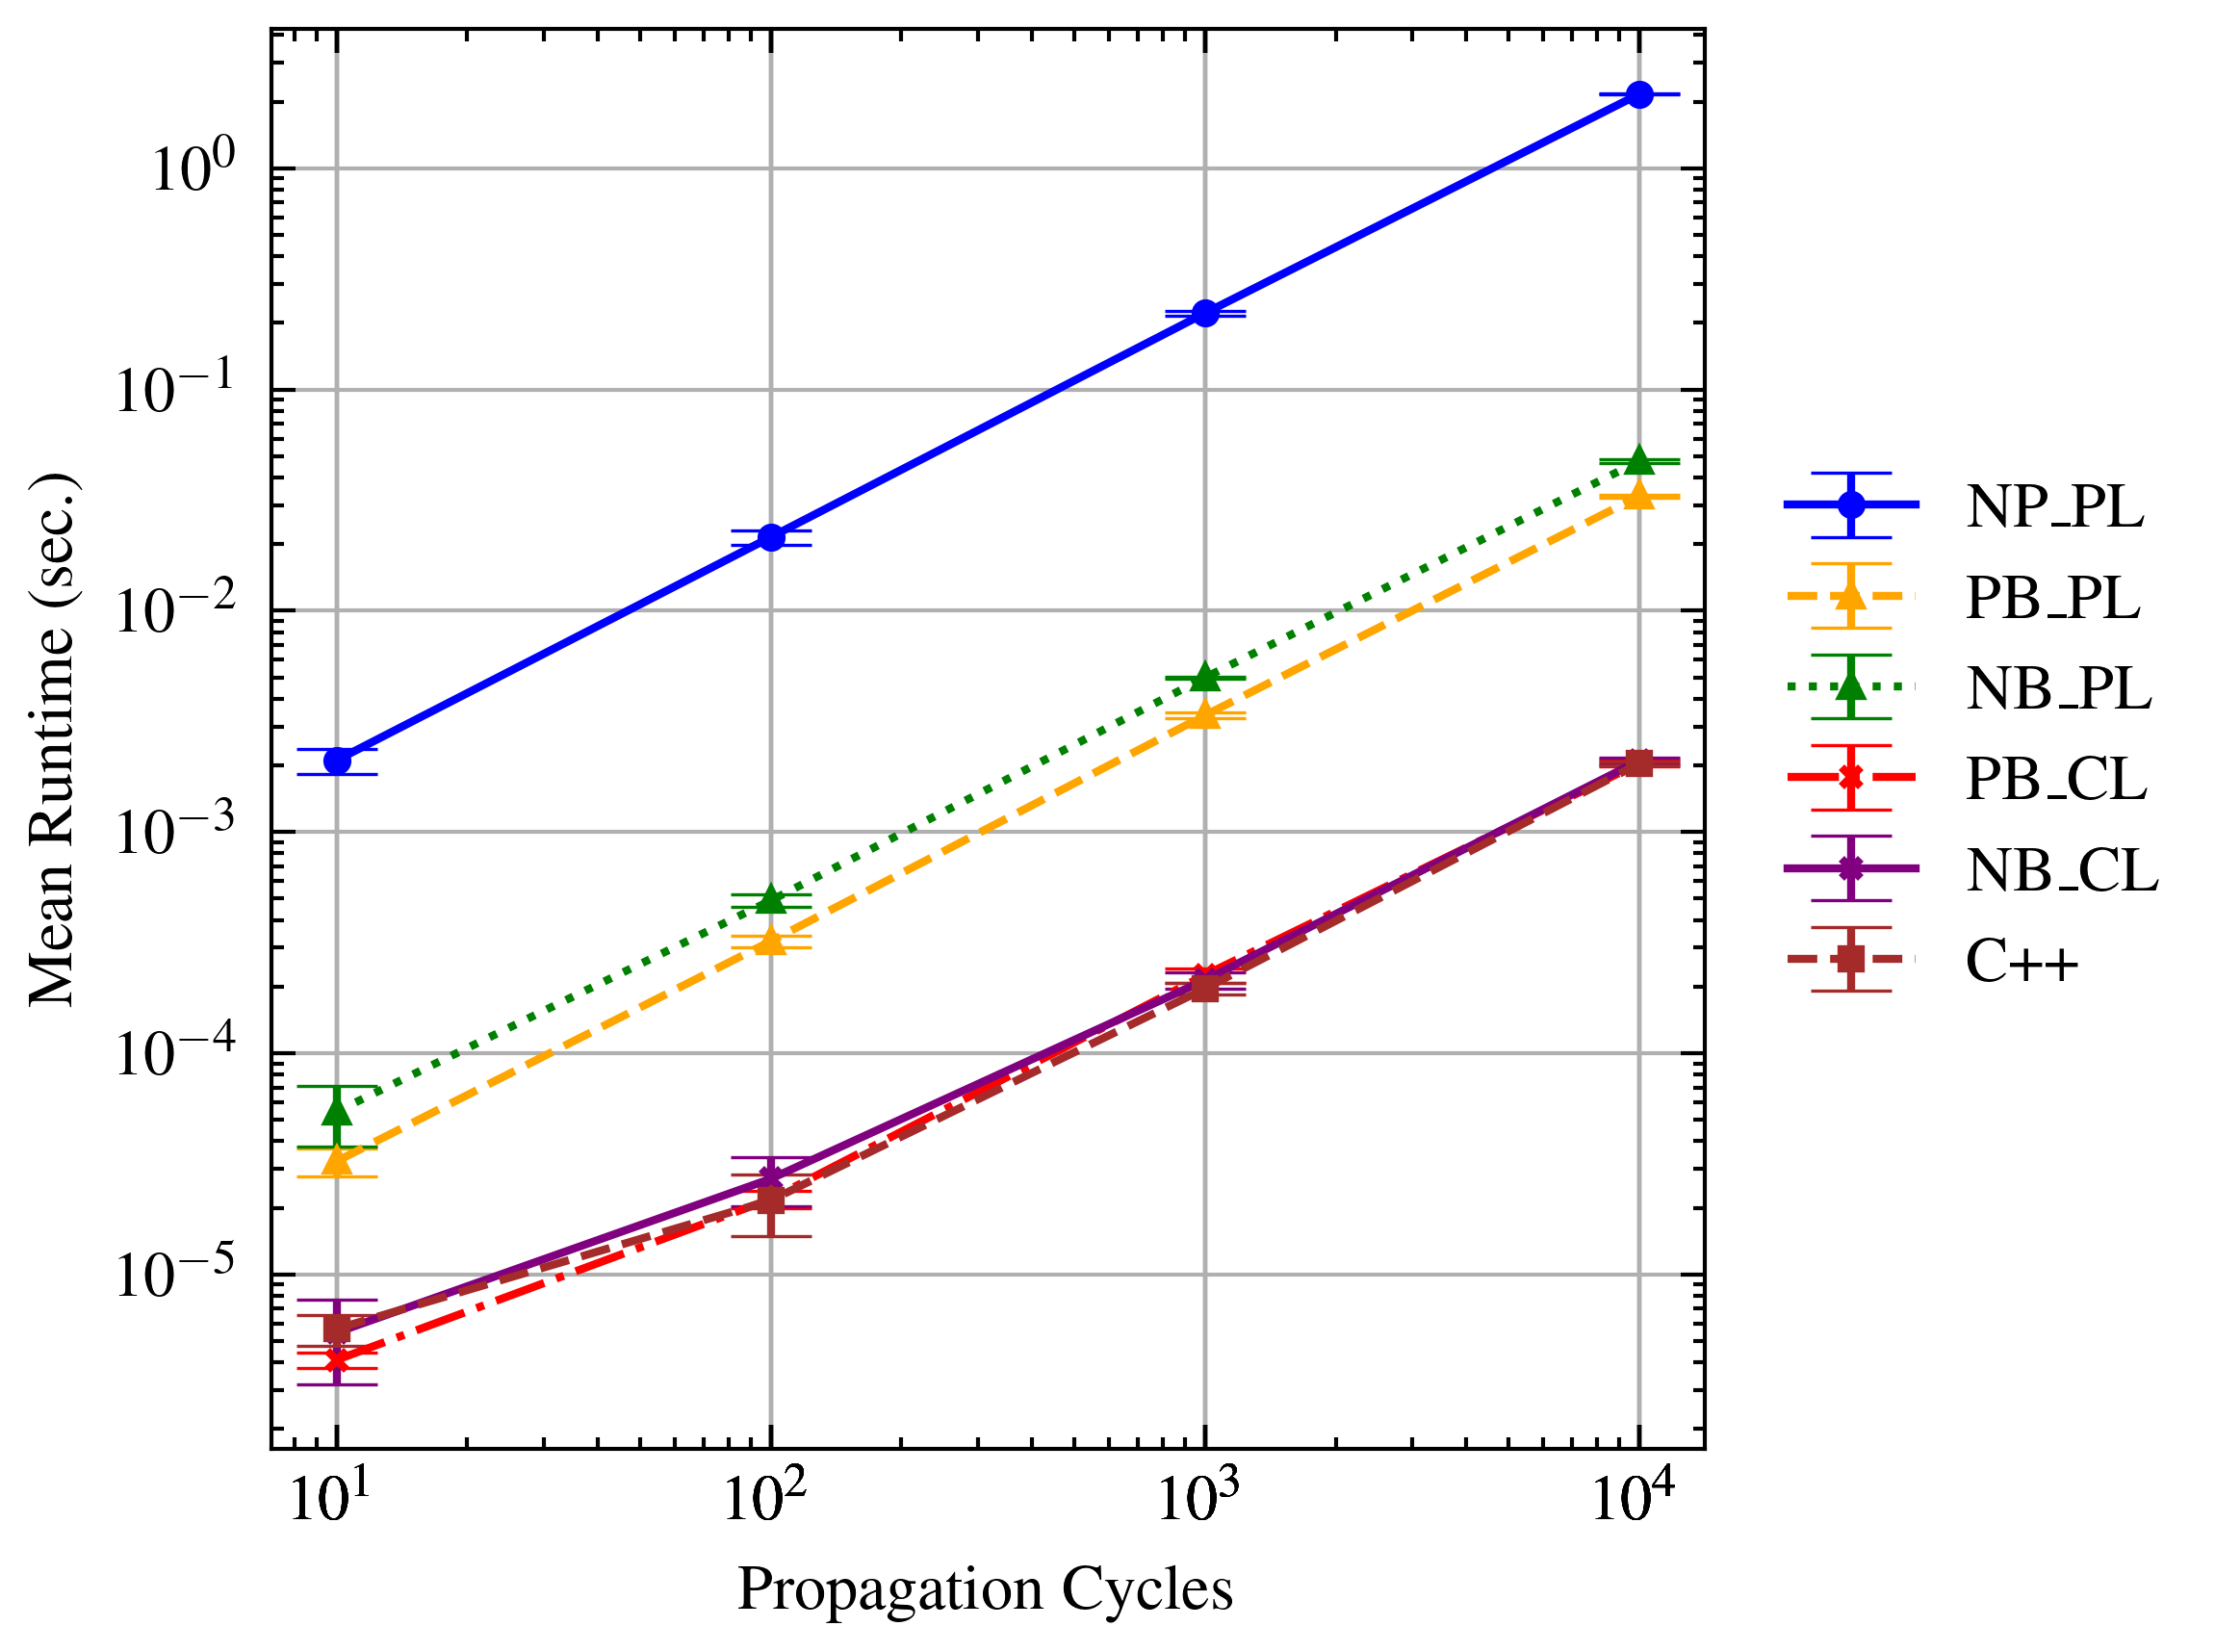

In [245]:
func = "ennui"
compiler = "Clang"
suffix = "line.eps"
filename = os.path.join(".", "fig", "_".join((func, compiler, suffix)))

this_df = df[(df["function"] == func) & (df["compiler"] == compiler)]
this_df
line_plot_box(this_df, column="algorithm", filename=filename,markers=["o","^","^","x","x","s"])

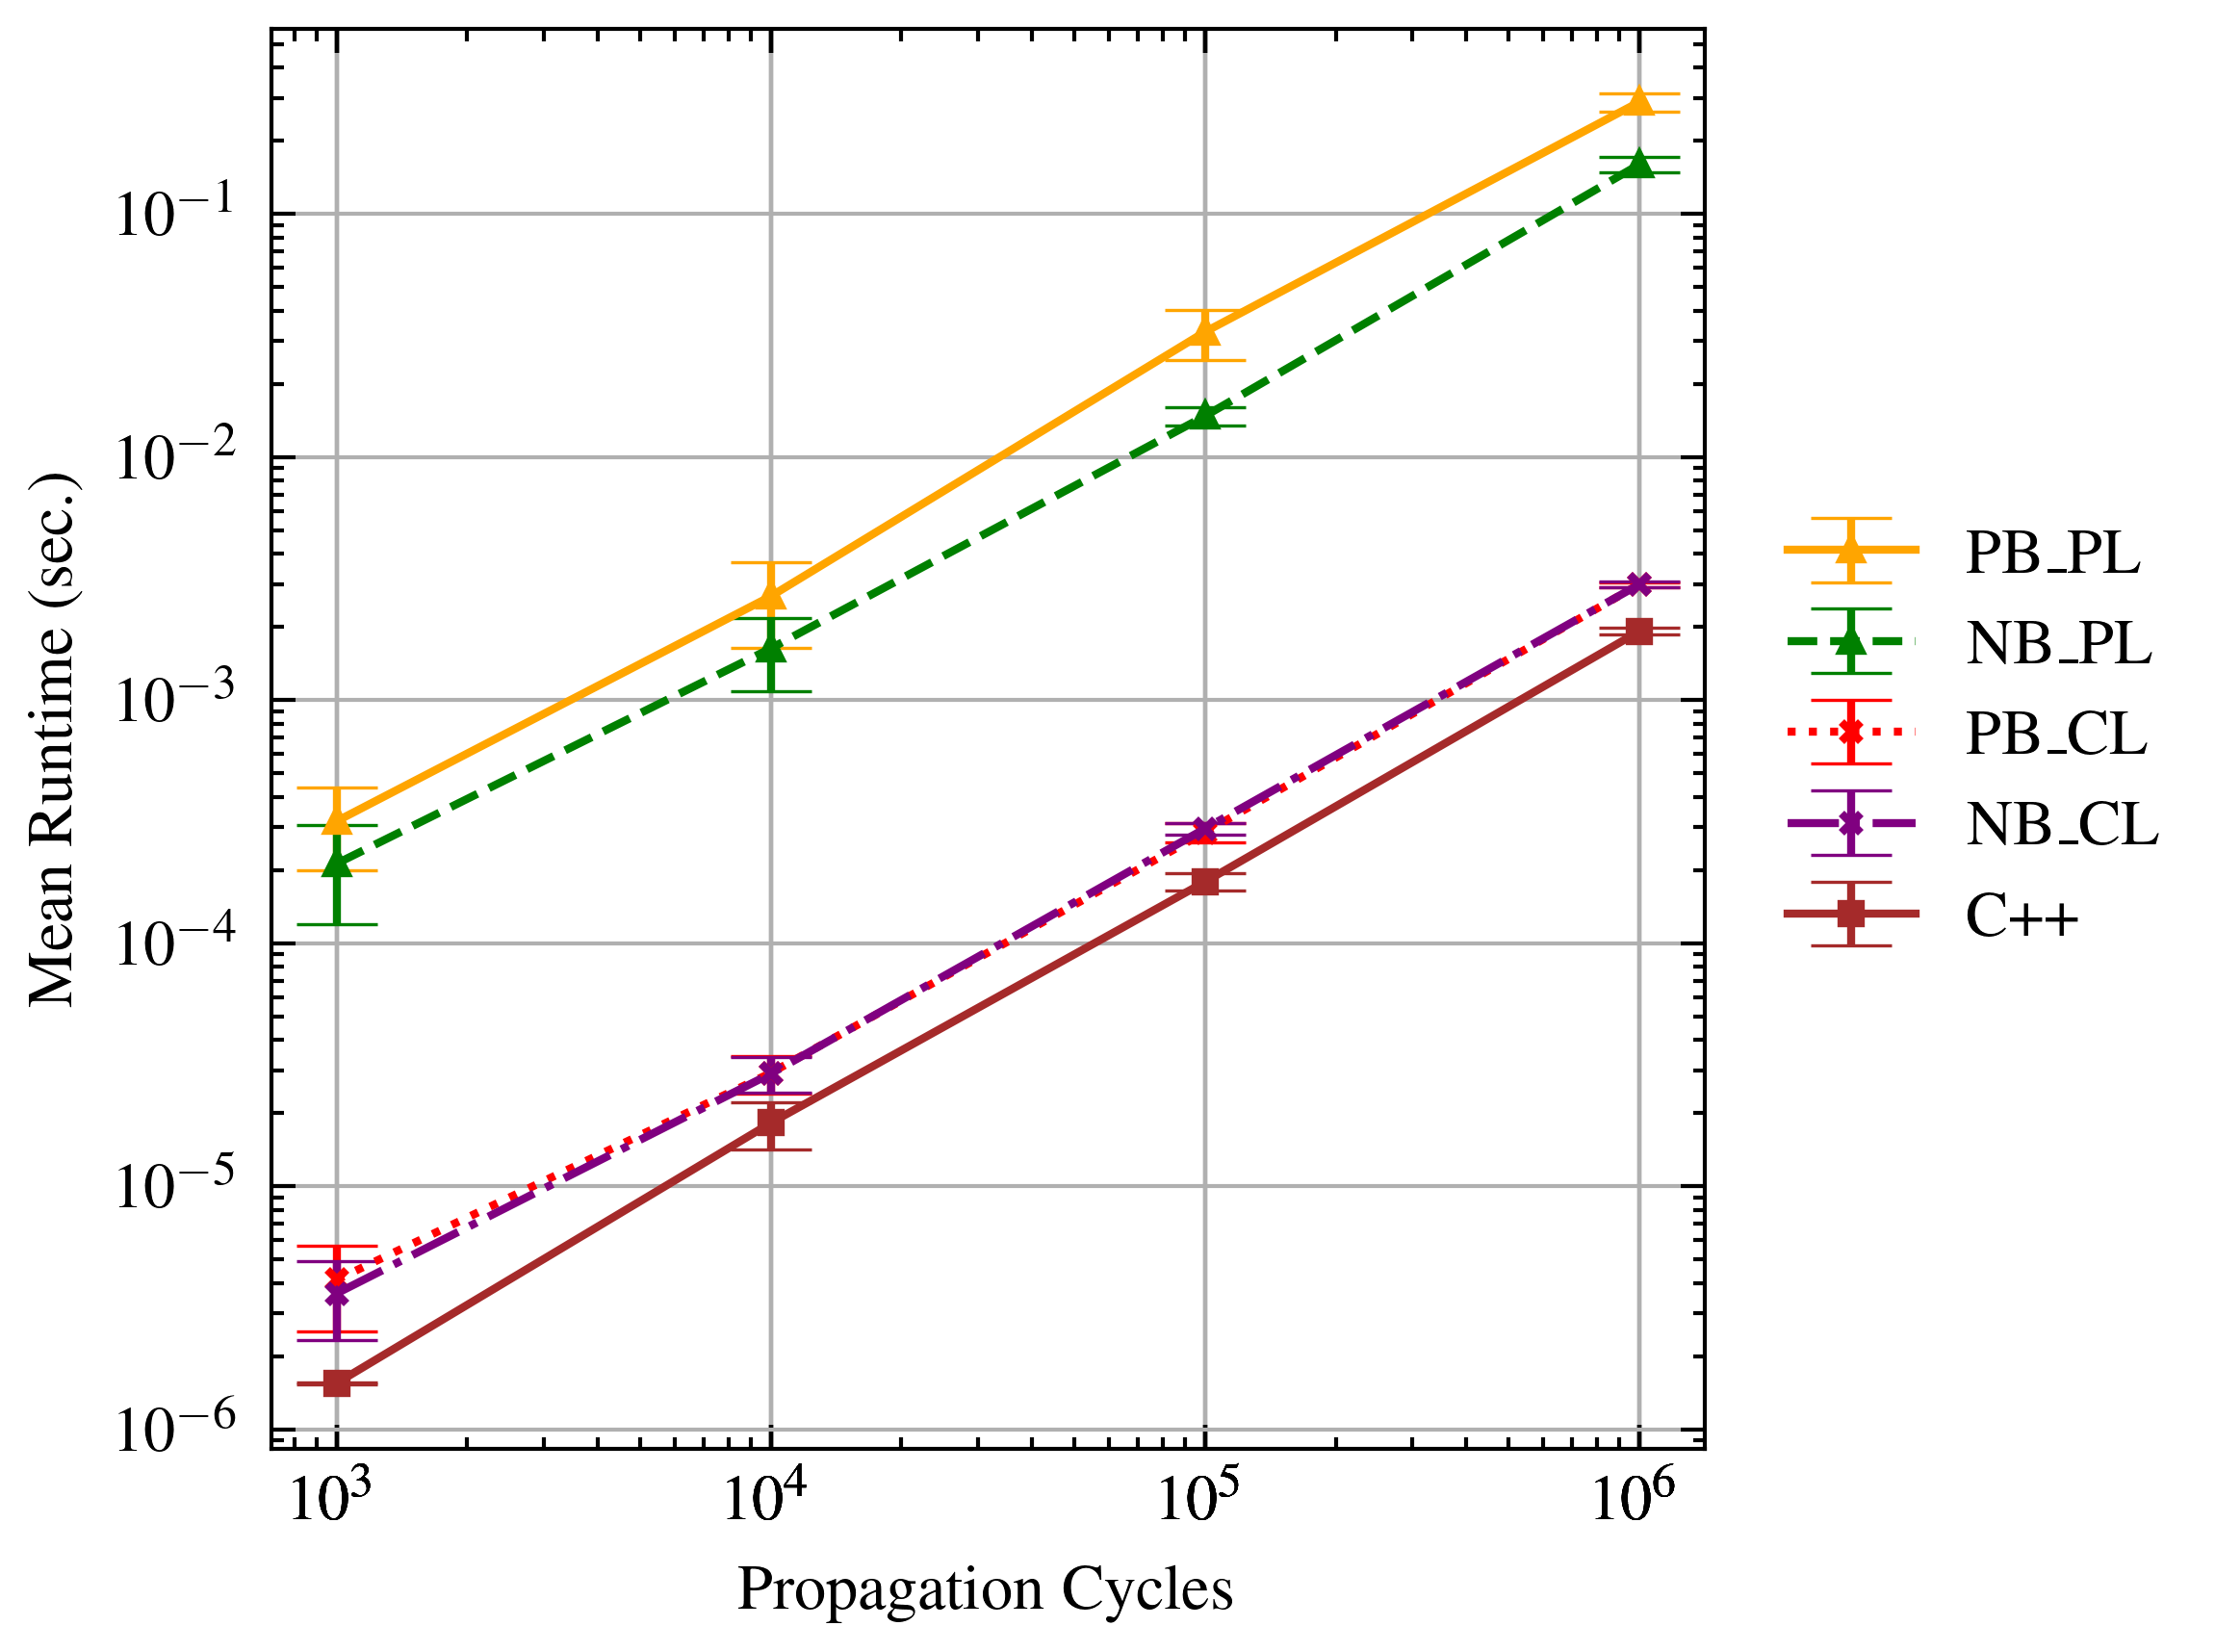

In [246]:
func = "rk4"
compiler = "GCC"
suffix = "line.eps"
filename = os.path.join(".", "fig", "_".join((func, compiler, suffix)))

this_df = df[(df["function"] == func) & (df["compiler"] == compiler)]
this_df
line_plot_box(this_df, column="algorithm", filename=filename,colors=["orange","green","red","purple","brown"],markers=["^","^","x","x","s"])

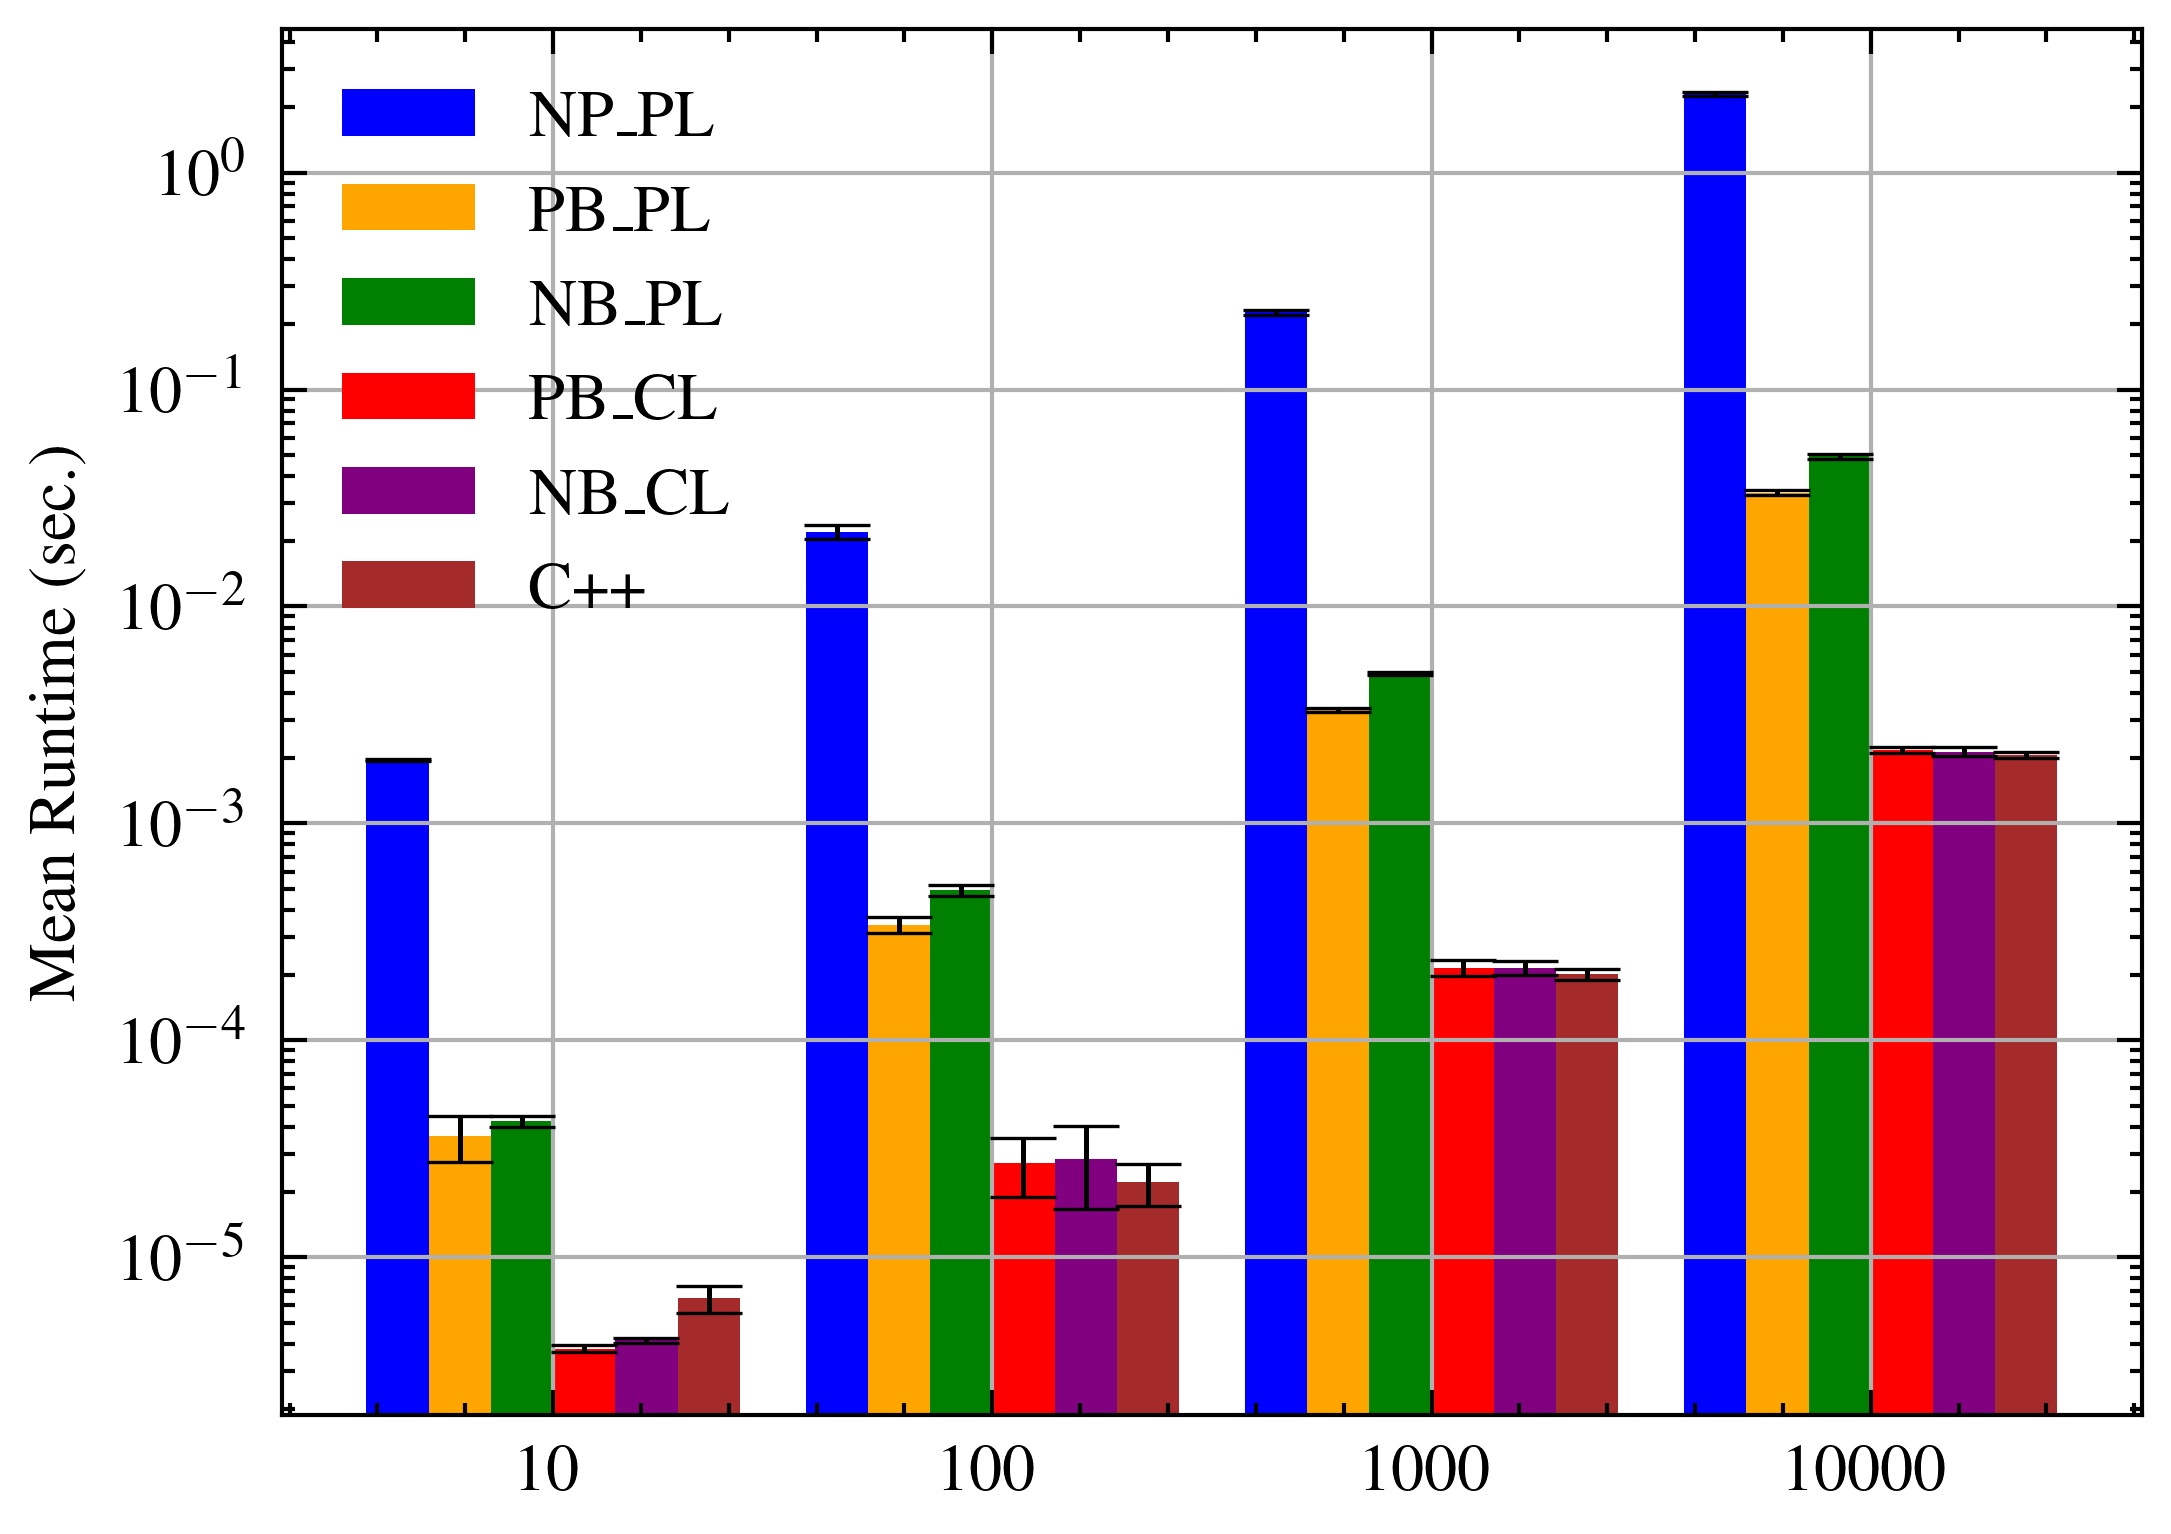

In [247]:
this_df = df[(df["function"] == "ennui") & (df["compiler"] == "GCC")]
this_df
bar_plot(this_df, "propagationCycles", "algorithm")
plt.show()

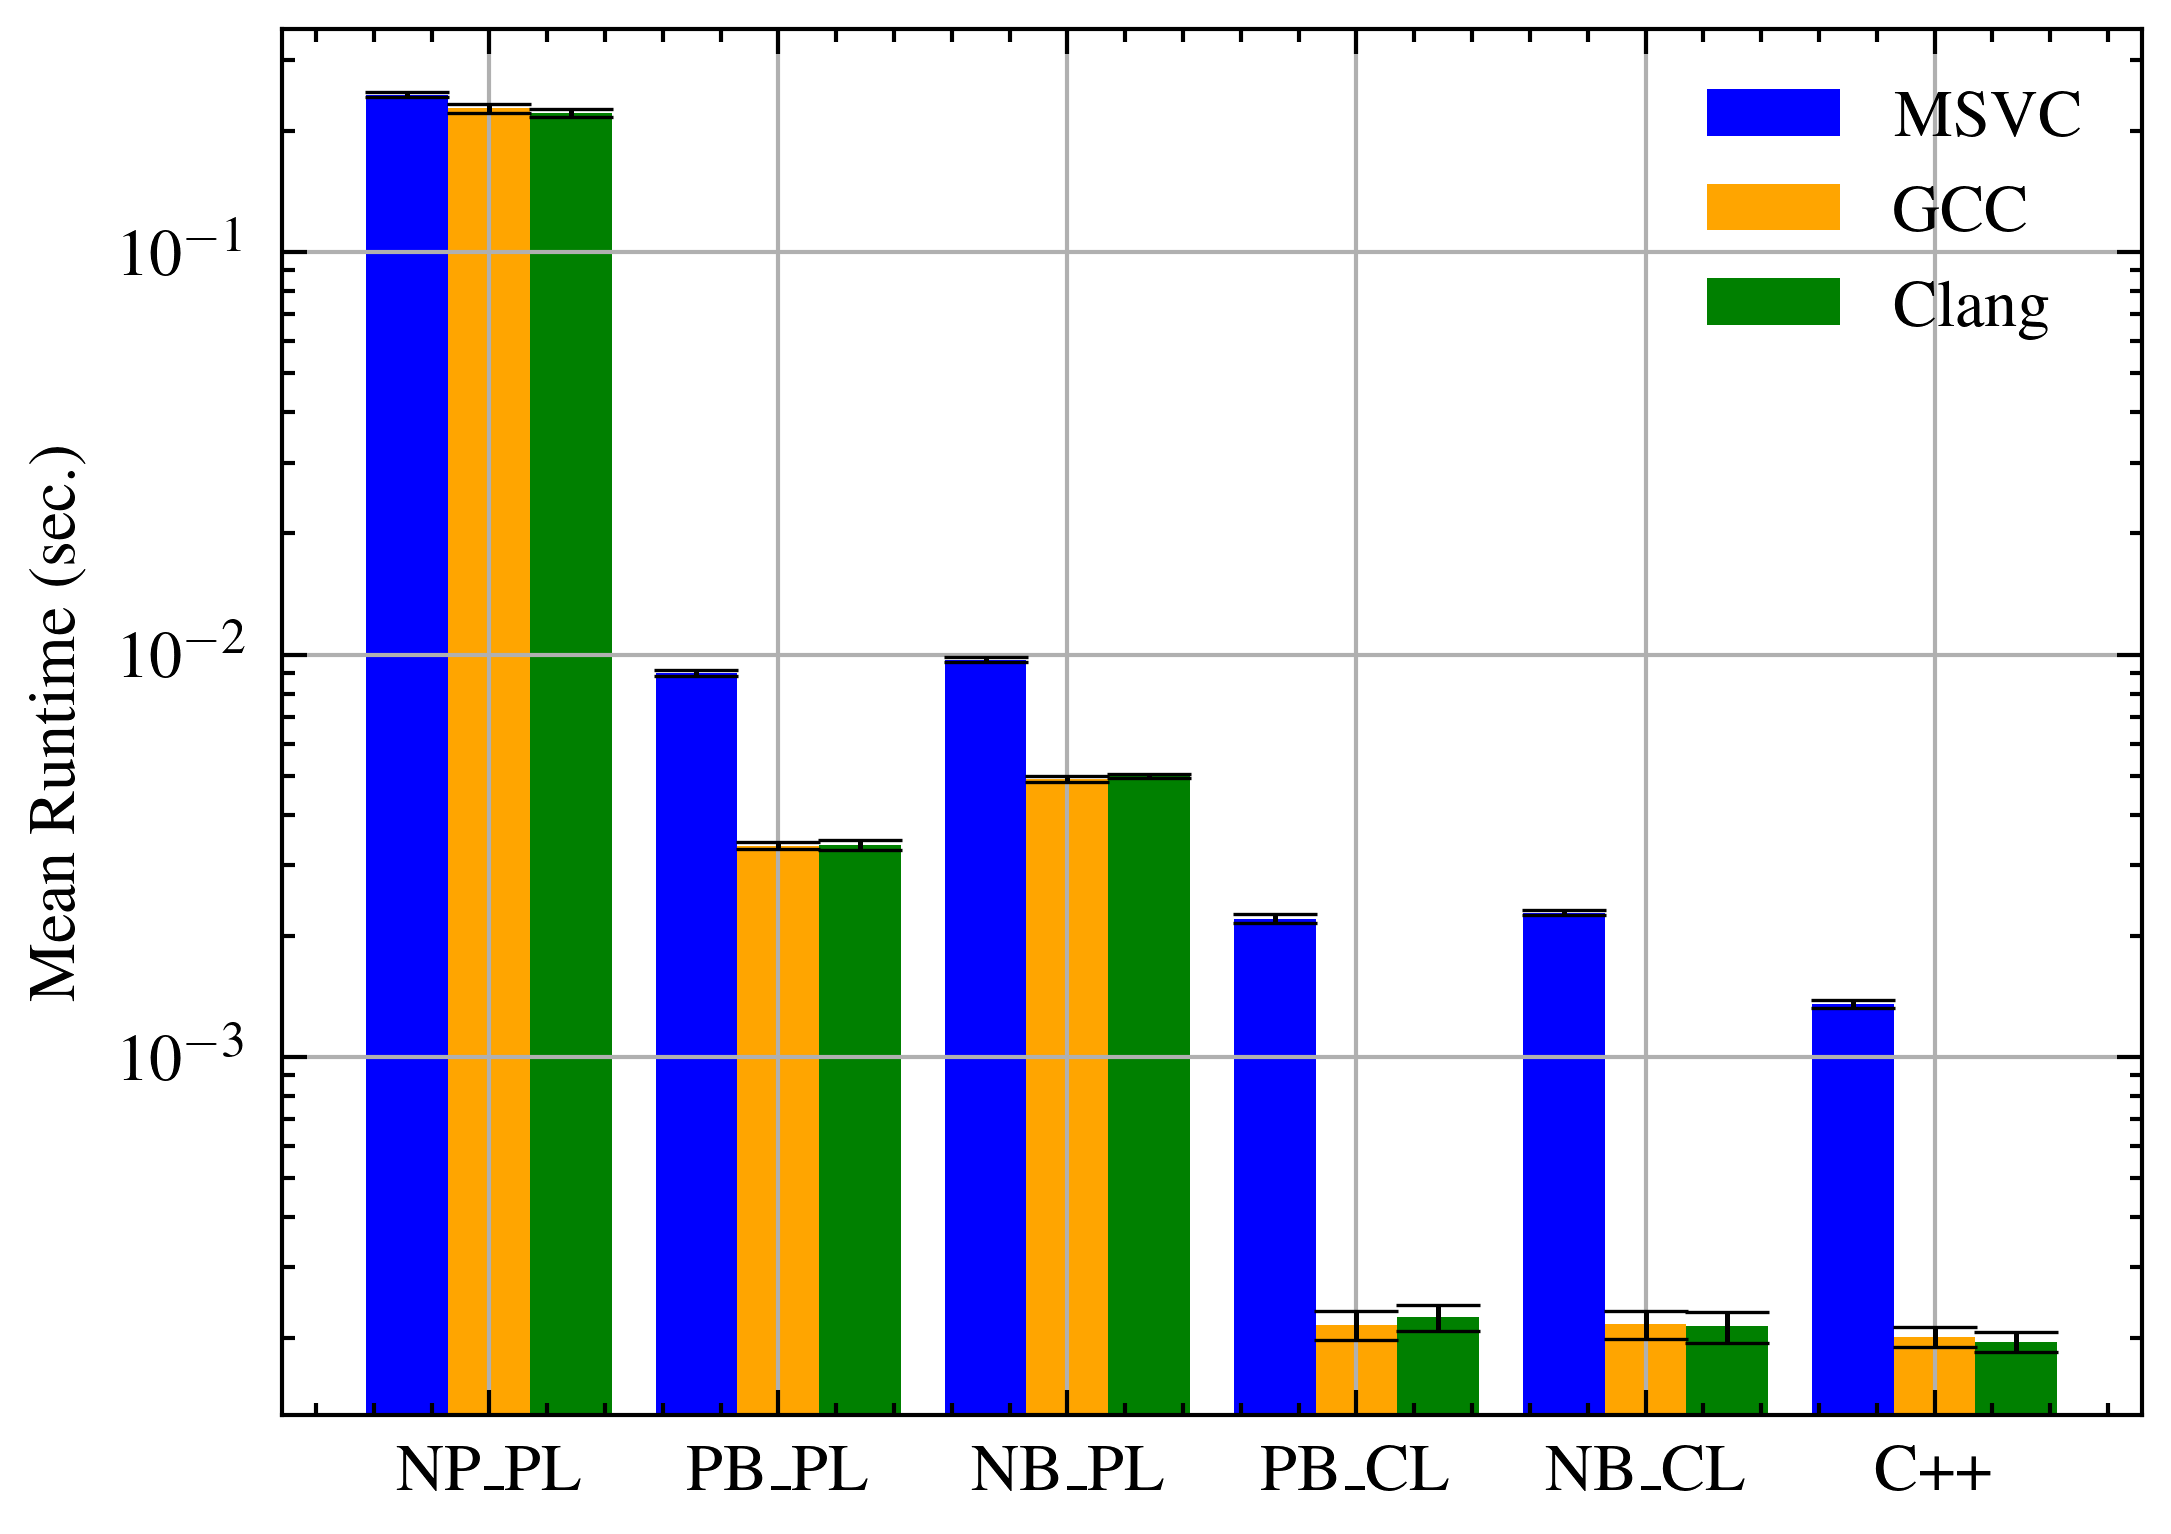

In [248]:
func = "ennui"
propagationCycles = 1000
suffix = "bar.eps"
filename = os.path.join(".", "fig", "_".join((func, str(propagationCycles), suffix)))

this_df = df[(df["function"] == func) & (df["propagationCycles"] == propagationCycles)]
this_df

bar_plot(this_df, "algorithm", "compiler", filename=filename,capsize=5) #using default color scheme
plt.legend(df["compiler"].unique(), loc="upper right")

if filename is not None:
    plt.savefig(filename, format="eps")  # Save the figure

plt.show()

## Memory Benchmark Plot

[[0.        0.        0.        0.        0.        0.       ]
 [0.00105   0.0010391 0.0010391 0.0010381 0.0010381 0.0010352]]


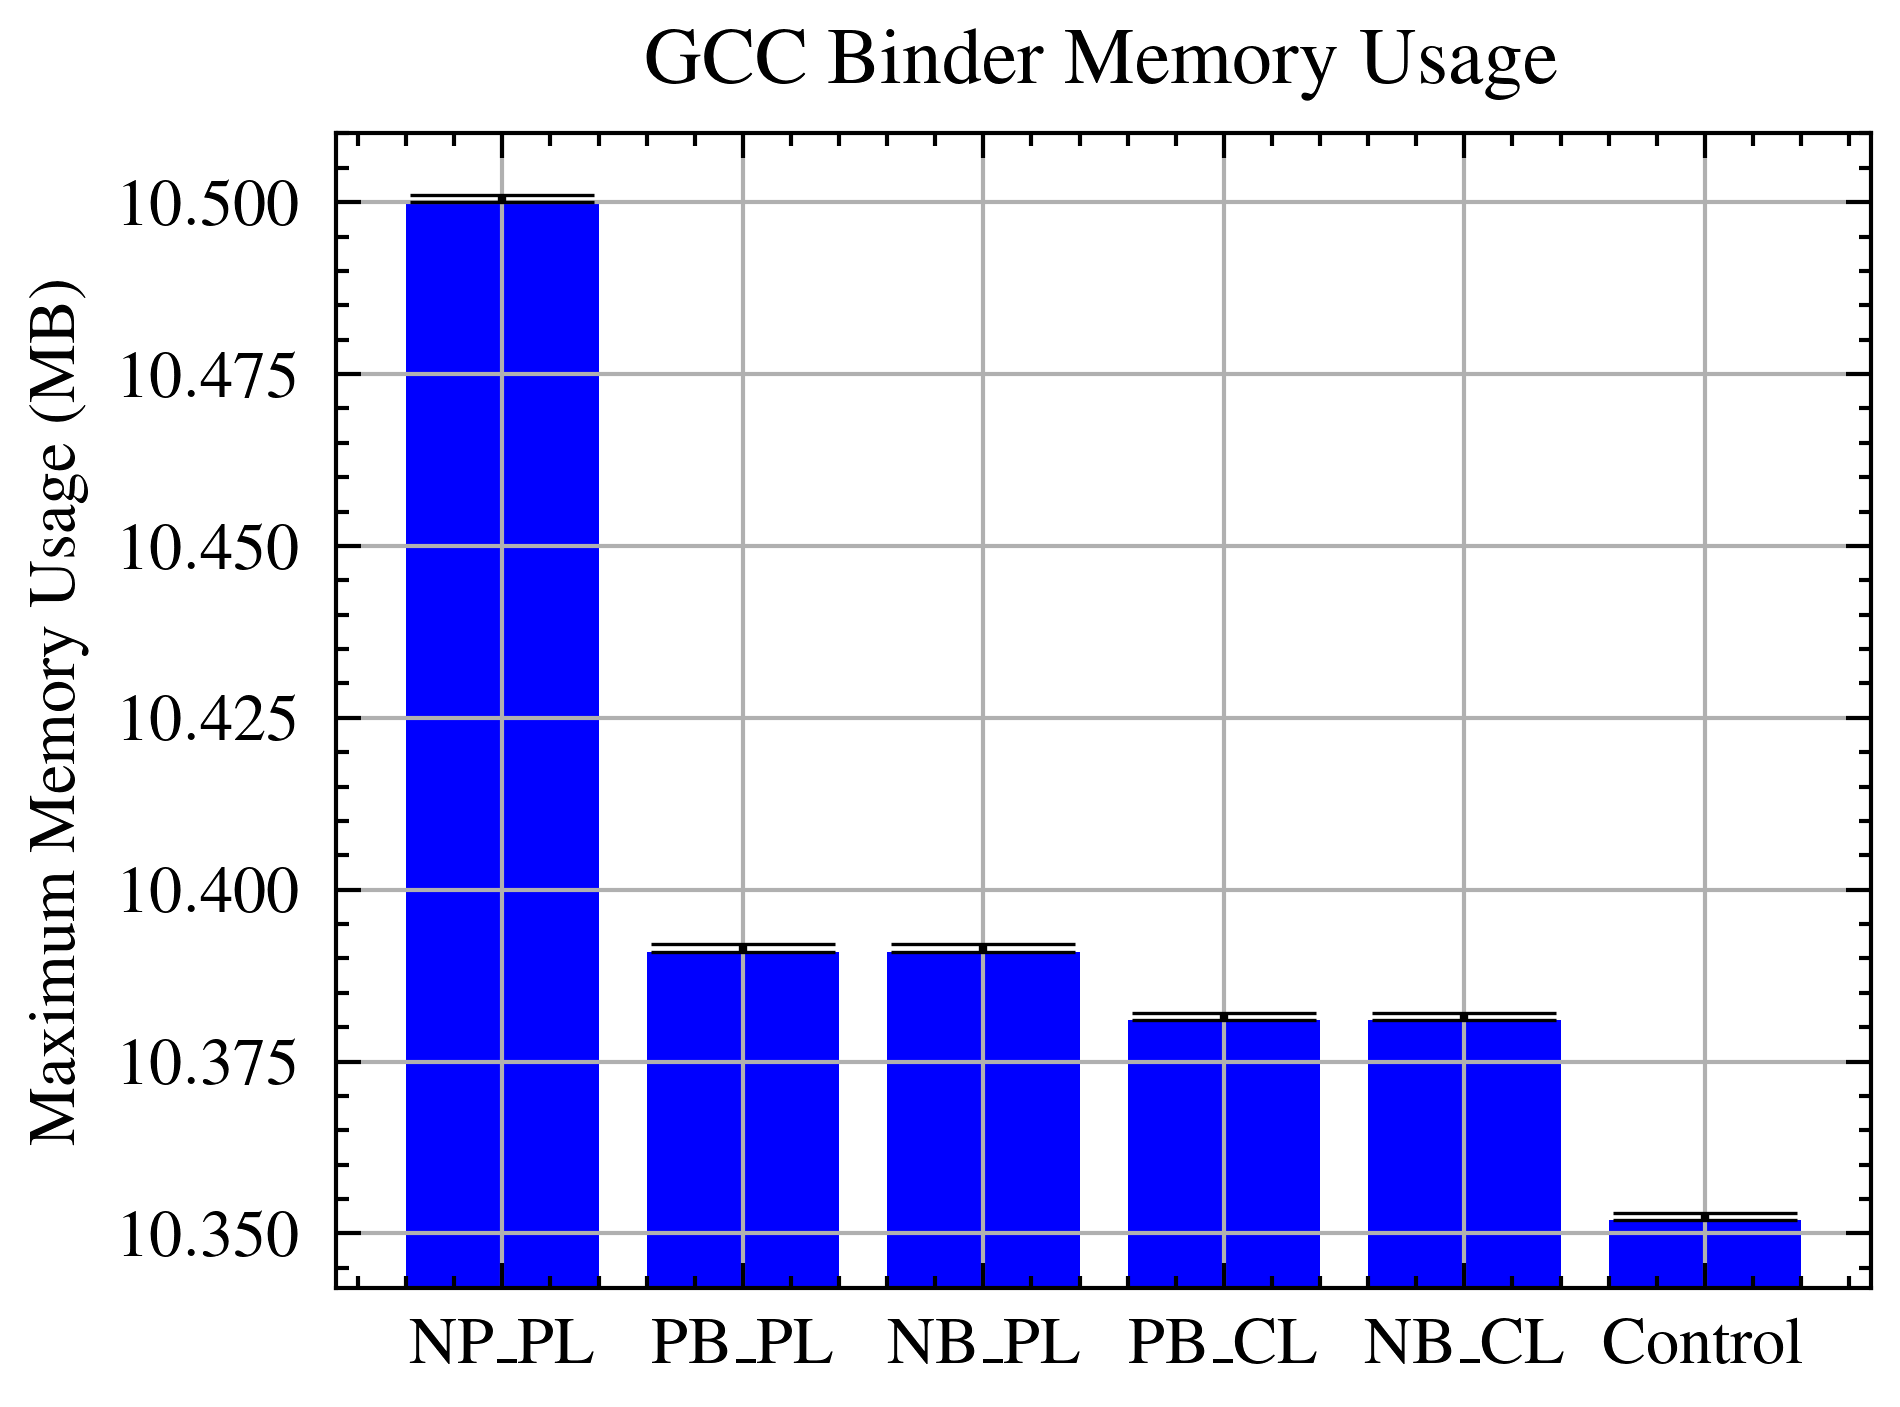

In [249]:

result_labels=["NP_PL","PB_PL","NB_PL","PB_CL","NB_CL","Control"]
gcc_results=[10.500,10.391,10.391,10.381,10.381,10.352]
gcc_results=np.array(gcc_results)

uncertainty=0.0001
gcc_uncertainties=uncertainty*gcc_results


lowerbound=np.zeros(gcc_uncertainties.shape)
errorbars=np.vstack((lowerbound,gcc_uncertainties))
xvals=np.arange(len(gcc_results))

print(errorbars)
#I will just use the GCC numbers becase the results between GCC and Clang are extremely similar to each other (memory not really affected by compiler it seems)

#simple bar plot
plt.style.use(["science", "ieee"])
plt.figure()
plt.clf()
plt.ylim(min(gcc_results)-0.01,max(gcc_results)+0.01)
plt.bar(xvals,gcc_results,color="blue")
plt.errorbar(
            xvals,
            gcc_results,
            yerr=errorbars,
            fmt="none",
            color="black",
            capsize=11,
            capthick=0.4,
            label="_nolegend_",
        )
plt.xticks(
        xvals,
        labels=result_labels,
    )

plt.grid()
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("GCC Binder Memory Usage")
filename=os.path.join("fig",r"output_gcc_memory_usage.eps")
plt.savefig(filename, format="eps")  # Save the figure
plt.show()

